# Double and Pseudo Double source plane cosmology forecast

Here we run the forecast for the w0waCDM cosmology and save the posteriors.

In [3]:
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import copy
import pickle
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from pdspl_analysis_utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs, OmegaMPrior

# --- Matplotlib Style ---
plt.style.use("../paper_style.mplstyle")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# POSTERIOR_DIR = "../data/posteriors/"
# FIGURES_DIR = "../figures/forecasts/"

In [5]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [6]:
# define hierarchical model
kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16 # from Auger et al. 2010 for SLACS lenses

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05

## Generate DSPL kwargs_likelihoods

In [10]:
########################################################
### Settings for population of DSPL
########################################################

num_systems_forecast = 100
rel_scatter_in_beta_E = 0.1 # relative scatter in beta_E
down_sampling_factor = 17 # down-sampling factor for the DSPL sample to speed up the forecast


kwargs_dspl_list = []

for i in range(num_systems_forecast):
    z_lens = np.random.uniform(low=0.1, high=1)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.normal(2, 1)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.normal(2, 1)
    if z1 > z2:
        z1, z2 = z2, z1

    kwargs_dspl_list.append(
        draw_lens_from_given_zs(z_lens, z1, z2,
                                lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                cosmo=cosmo_true,
                                sigma_beta=rel_scatter_in_beta_E,
                                # sigma_beta=sigma_beta,
                                with_noise=True,
                                down_sampling=down_sampling_factor)
                                )

## hierArc sampling settings

In [11]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},

    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5, "gamma_pl_sigma": 0.0, "lambda_mst_sigma": 0.0},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5, "gamma_pl_sigma": 0.32, "lambda_mst_sigma": 0.10},
    "kwargs_fixed_lens": {
        # "gamma_pl_sigma": gamma_pl_sigma,
        # "lambda_mst_sigma": lambda_mst_sigma
    }
}


kwargs_sampler = {
                "custom_prior": None, #OmegaMPrior(0.3, 0.05),
                "interpolate_cosmo": True,
                "num_redshift_interp": 100,
                "cosmo_fixed": None,
                 }



In [12]:
dspl_sampler = MCMCSampler(
        kwargs_dspl_list,
        cosmology=cosmology,
        kwargs_model=kwargs_model,
        kwargs_bounds=kwargs_bounds,
        **kwargs_sampler
    )

In [13]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}


with Pool(processes=18) as pool:
    kwargs_emcee_key = copy.deepcopy(kwargs_emcee)
    dspl_emcee_sampler = dspl_sampler.get_emcee_sampler(**kwargs_emcee_key,
                                                    pool=pool,
                                                #    backend=forecast_samples[key]['emcee_backend']
                                                    )

/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/lens_sample_likelihood.py:71: RuntimeWarning: overflow encountered in scalar add
  log_likelihood += lens.lens_log_likelihood(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/lens_sample_likelihood.py:71: RuntimeWarning: overflow encountered in scalar add
  log_likelihood += lens.lens_log_likelihood(
/home/paras/sharmapyenv/lib64/python3.12/site-packages/hierarc/Likelihood/LensLikelihood/d

In [44]:
chain = Chain.from_emcee(
    dspl_emcee_sampler,
    dspl_sampler.param_names(latex_style=True),
    name="DSPL (1700)",
    discard = 500,
    thin = 10,
    kde = 1.5,
    smooth = 1.0,
)

In [45]:
def reduced_chi_square(chain, dof, discard=100, thin=1, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.nanmedian(reduced_chi2_samples)

    return median_reduced_chi2


num_params = len(dspl_sampler.param_names())
num_data_points = num_systems_forecast
dof = num_data_points - num_params
reduced_chi2 = reduced_chi_square(dspl_emcee_sampler, dof)

# print reduced chi-square for each chain
print(f"Reduced chi-square for DSPL (1700): {reduced_chi2:.2f}")

Reduced chi-square for DSPL (1700): inf


In [46]:
dspl_sampler.param_names()

['om',
 'w0',
 'wa',
 'lambda_mst',
 'lambda_mst_sigma',
 'gamma_pl_mean',
 'gamma_pl_sigma']

## Make combined plot

Parameter $w_0$ in chain DSPL (1700) is not constrained


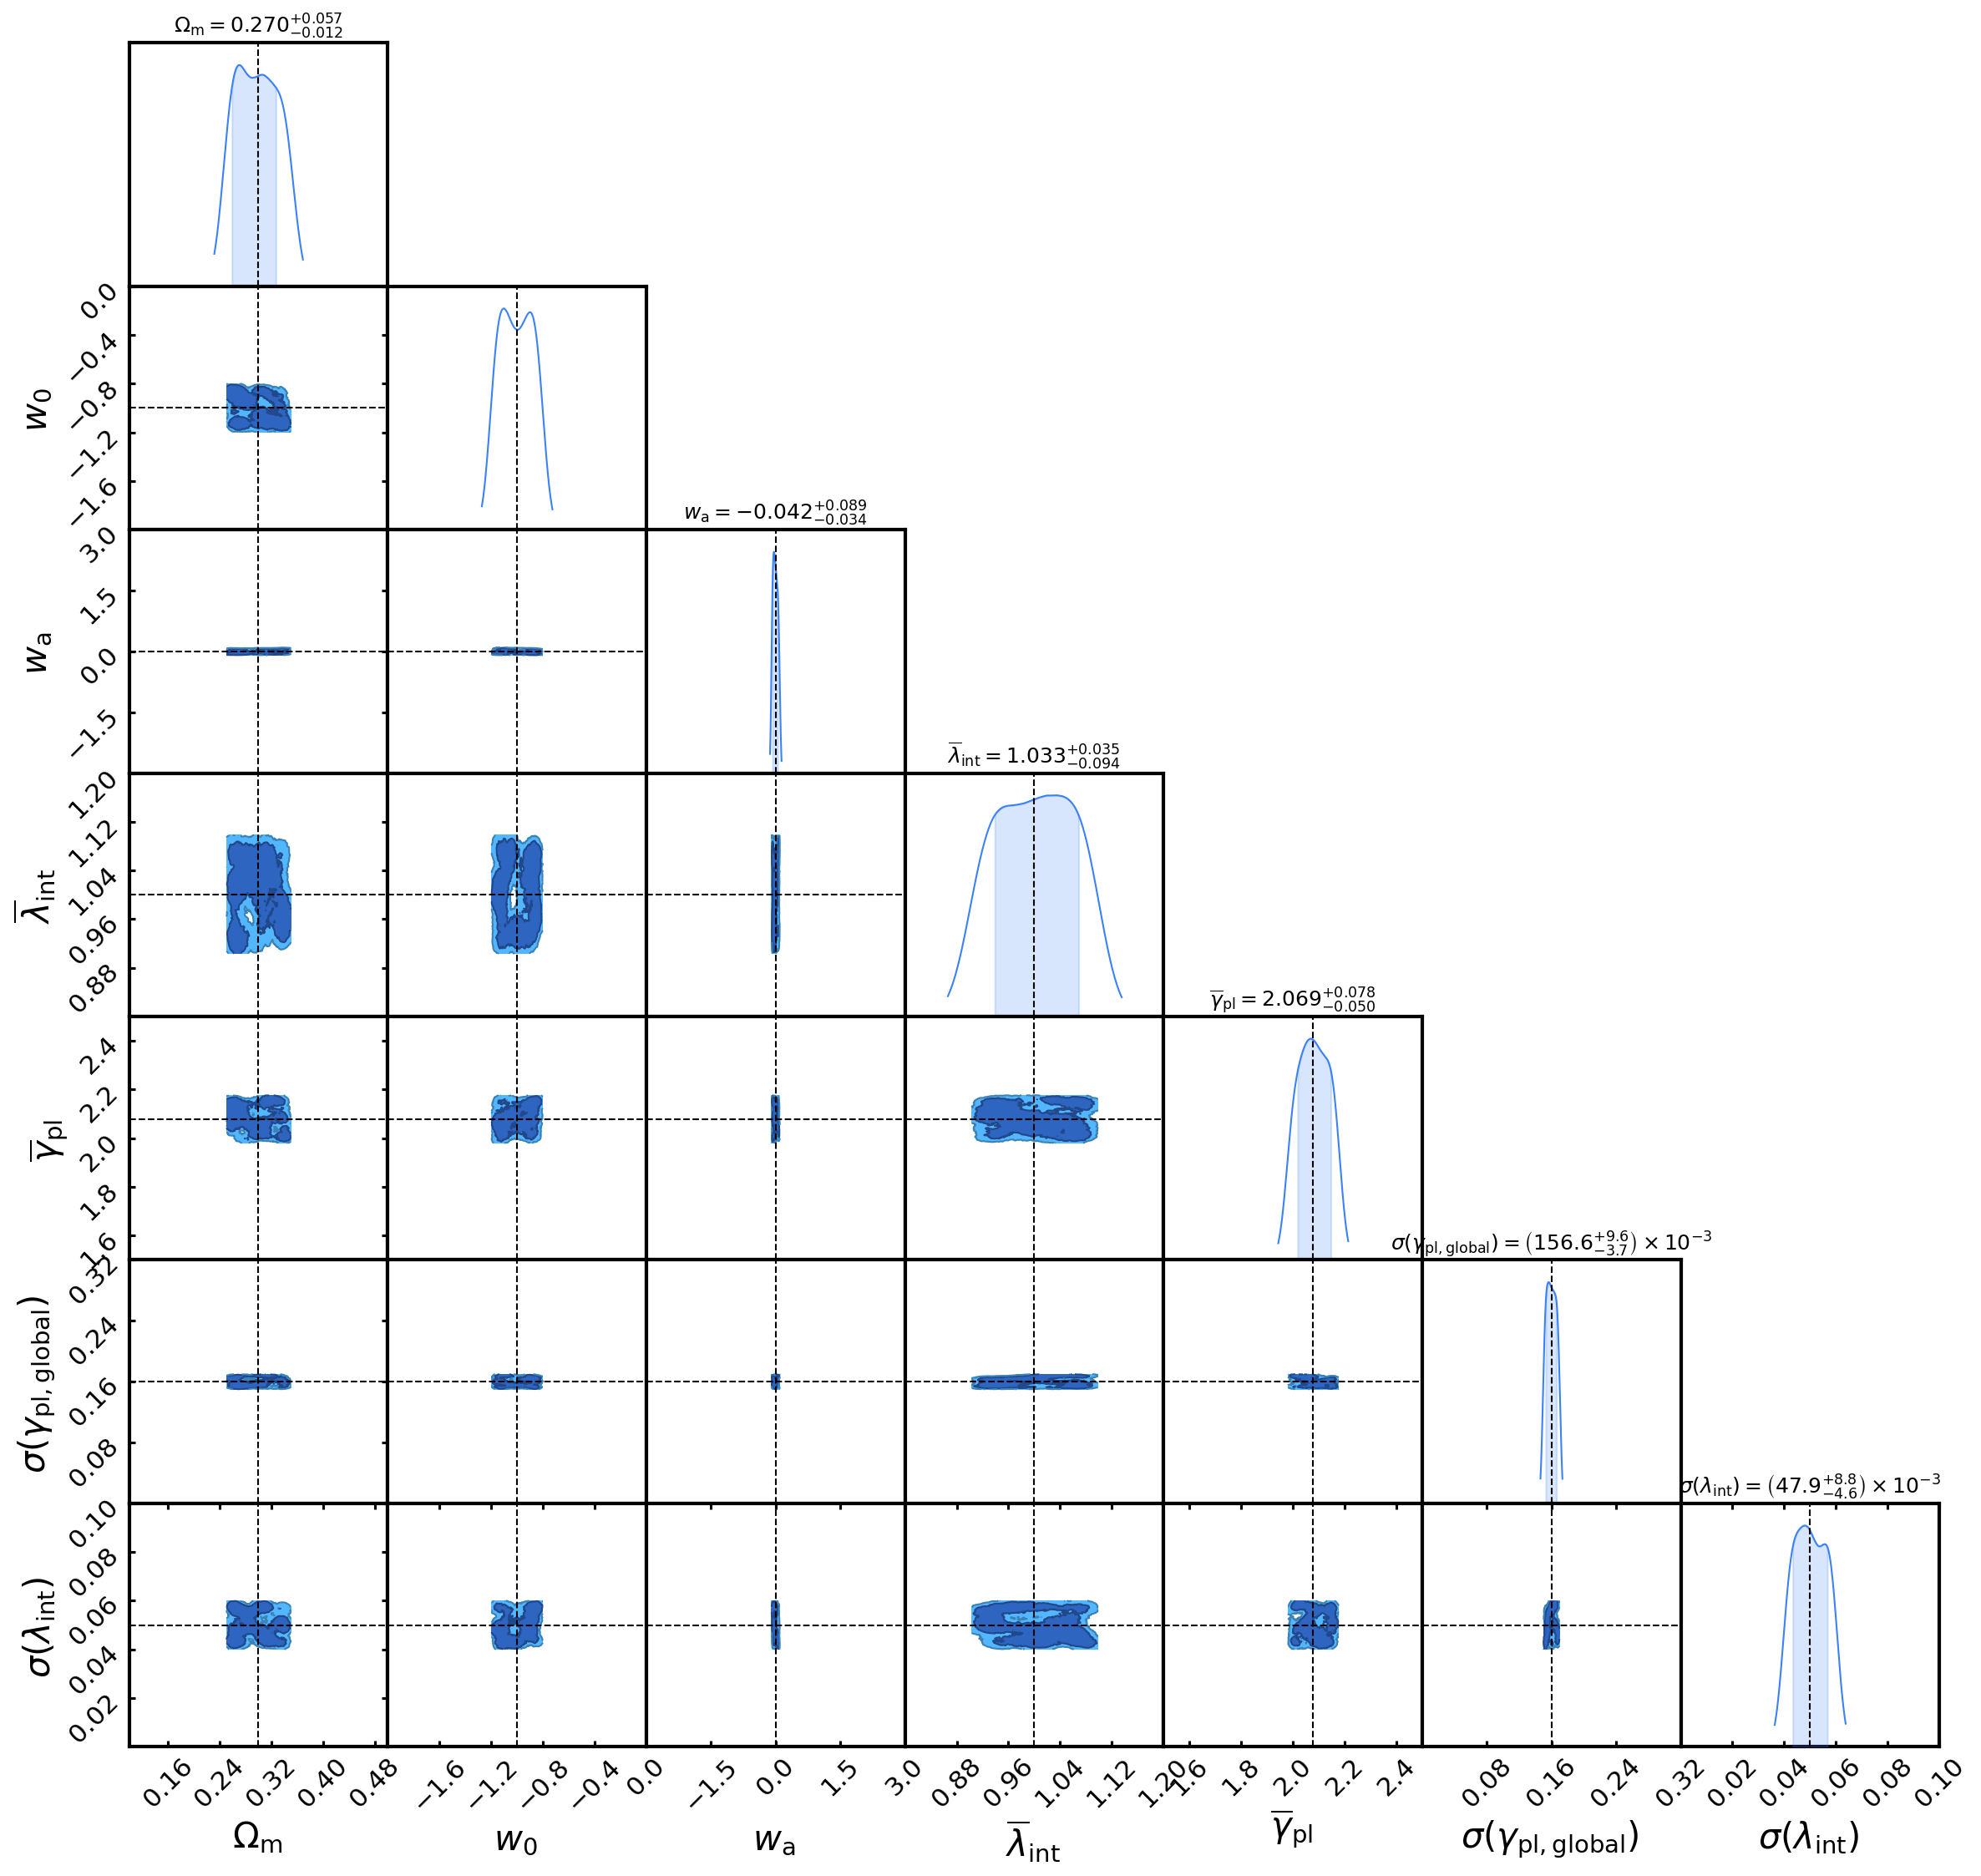

In [47]:
consumer = ChainConsumer()

consumer.add_chain(chain)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
        r"$\sigma(\lambda_{\rm int})$": lambda_mst_sigma,
    }
)
)

##### configure plot settings

extents = {
                r"$w_0$": [-2, 0],
                r"$w_{\rm a}$": [-3, 3],
                r"$\Omega_{\rm m}$": [0.1, 0.5],
                r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
                r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
                r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
                r"$\sigma(\lambda_{\rm int})$": [0.0, 0.10],
            }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

# consumer.set_plot_config(
#         PlotConfig(
#             sigmas=[1, 2],
#             # extents=extents,
#             plot_hists=True,
#             legend_kwargs={
#                 "loc": "upper left",
#                 "bbox_to_anchor": (-1, 1.),
#                 "fontsize": 15,
#             },
#             legend_artists=False,
#             tick_font_size=15,
#             label_font_size=20,
#         )
#     )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            '$\\sigma(\\gamma_{\\rm pl, global})$',
            '$\\sigma(\\lambda_{\\rm int})$',
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)

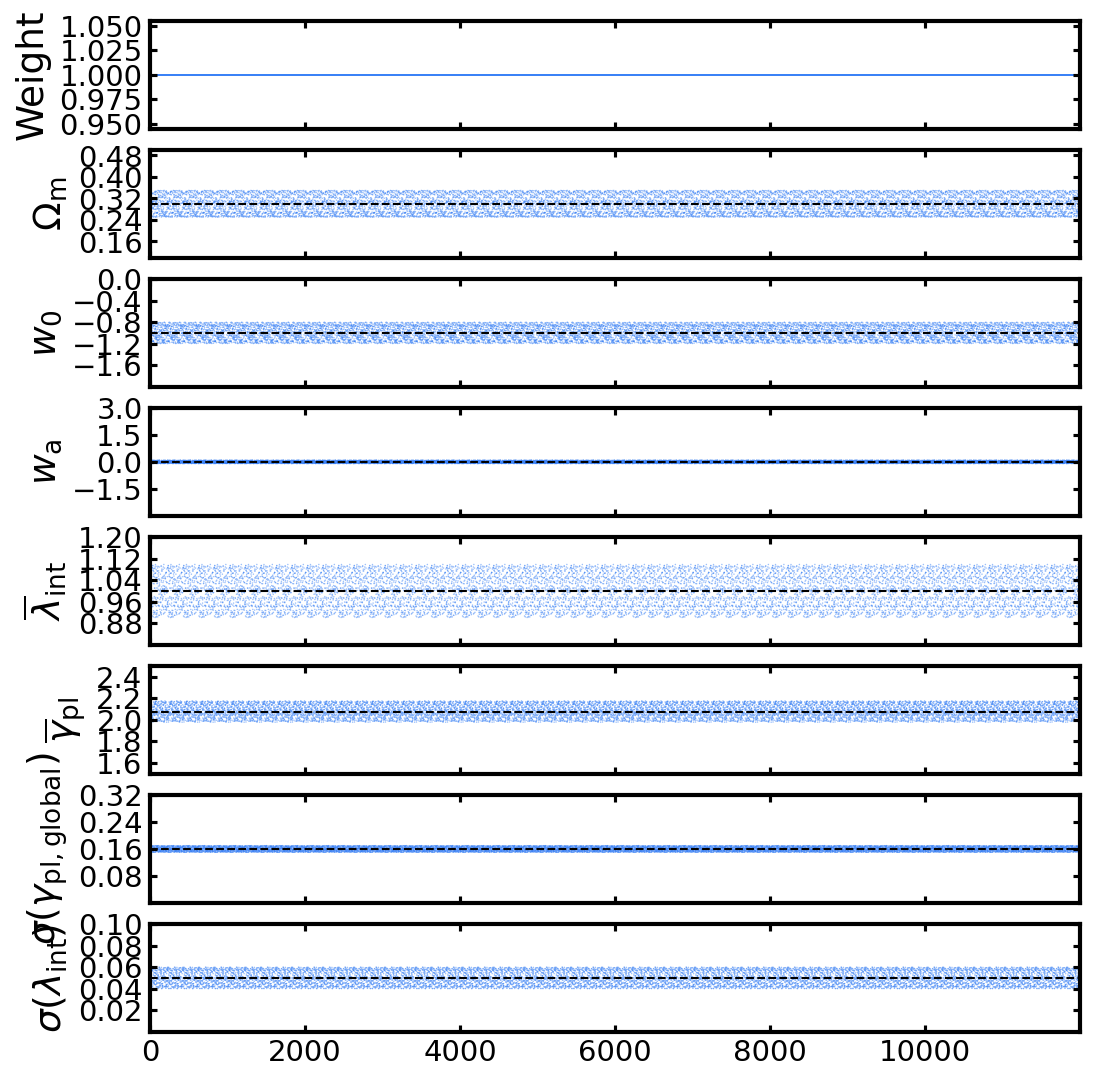

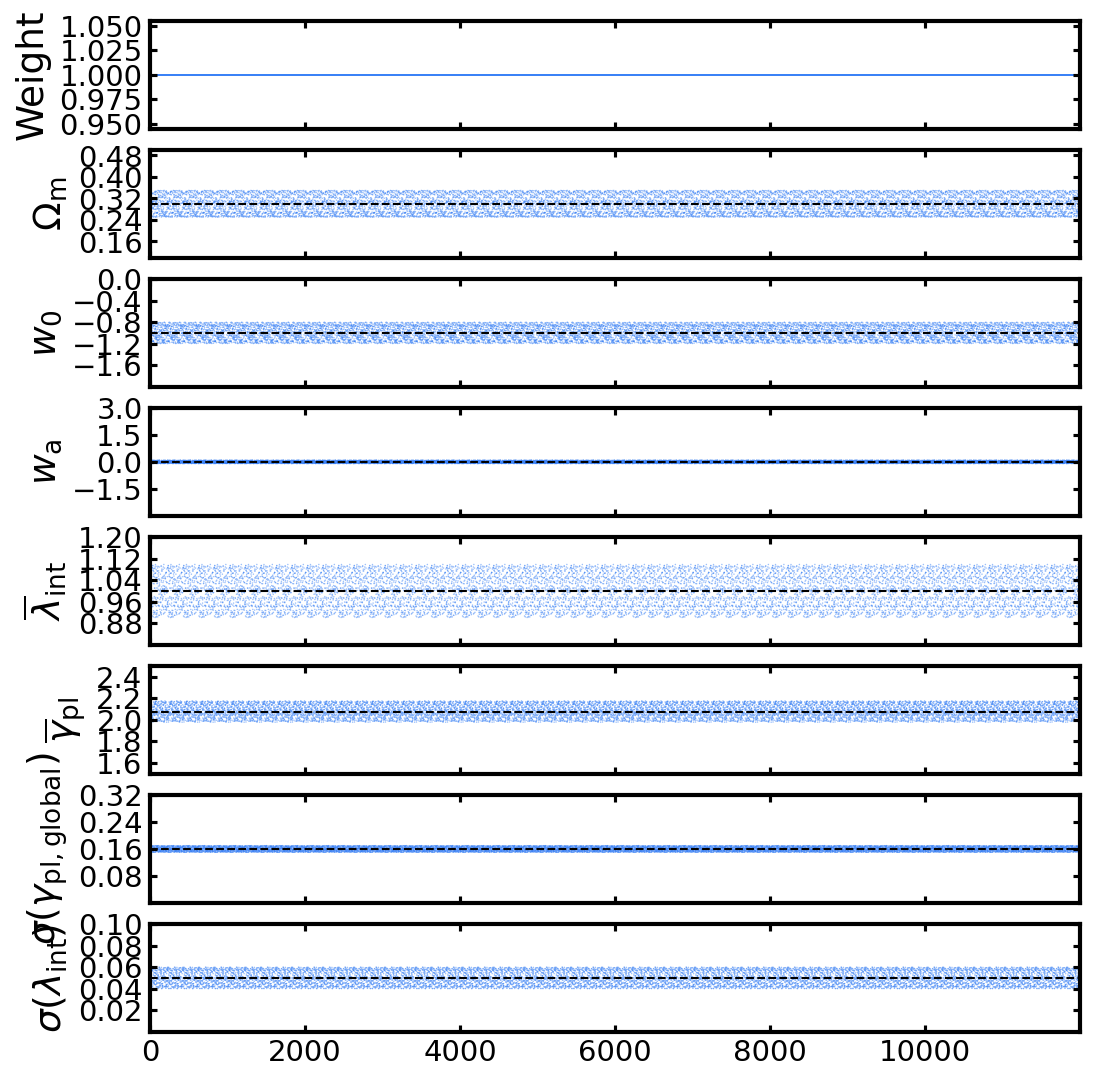

In [48]:
# plot walks
consumer.plotter.plot_walks(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            '$\\sigma(\\gamma_{\\rm pl, global})$',
            '$\\sigma(\\lambda_{\\rm int})$',
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)